In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.0.0-beta1'

In [53]:
import os
import re
import time
import h5py
import shutil
import skimage
import imageio
import numpy as np

from PIL import Image
from glob import glob
from tqdm import tqdm
tqdm.pandas(desc="progress-bar")

import matplotlib.pyplot as plt
%matplotlib inline

from IPython.display import clear_output

# don't print matching warnings
import warnings
warnings.filterwarnings('ignore') 

### Download dataset and unpack it

In [4]:
_URL = 'https://s3.amazonaws.com/nist-srd/SD18/sd18.zip'

path_to_zip = tf.keras.utils.get_file('sd18.zip', origin=_URL, extract=True)
PATH = os.path.join(os.path.dirname(path_to_zip), 'sd18/')

### Organize all images

In [5]:
BUFFER_SIZE = 400
BATCH_SIZE = 1
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [6]:
if not os.path.isdir('data'):
    os.mkdir('data')

filenames = glob(PATH + 'single/f1_p1/*/*.png')
for filename in tqdm(filenames):
    indx = filename.split('/')[-1].split('_')[0]
    # remove leading zeros from index
    indx = re.sub(r'(?<!\d)0+', '', indx)
    side = filename.split('/')[-1].split('_')[2].split('.')[0].lower()
    new_file = 'data/mugshot_{}.{}.png'.format(side, indx)
    shutil.copyfile(filename, new_file)

100%|██████████| 2434/2434 [00:13<00:00, 186.18it/s]


In [7]:
# Convert Grayscale to RGB 
# Resize to (256, 256)
filenames = glob('data/*.png')
for filename in tqdm(filenames):
    im = skimage.io.imread(filename)
    im = skimage.color.gray2rgb(im)
    im = skimage.transform.resize(im, (256, 256), anti_aliasing=True)
    im = skimage.util.img_as_ubyte(im)
    skimage.io.imsave(filename, im)

100%|██████████| 2434/2434 [05:35<00:00,  8.49it/s]


In [8]:
# Flip L to R
filenames = glob('data/mugshot_l.*.png')
for filename in tqdm(filenames):
    im = skimage.io.imread(filename)
    im = np.fliplr(im)
    skimage.io.imsave(filename, im)
    # rename file
    new_filename = filename.replace('_l', '_r')
    os.rename(filename, new_filename)

100%|██████████| 146/146 [00:03<00:00, 42.74it/s]


In [9]:
# Combine F and R image
filenames = sorted(glob('data/mugshot_f.*.png'))
k = 0
for filename in tqdm(filenames):
    images = [filename, filename.replace('_f', '_r')]
    images = [Image.open(image) for image in images]
    
    min_shape = sorted([(np.sum(image.size), image.size) for image in images])[0][1]
    imgs_comb = np.hstack((np.asarray(image.resize(min_shape)) for image in images))

    imgs_comb = Image.fromarray(imgs_comb)
    imgs_comb.save('data/mugshot_comp.{}.png'.format(k))
    k += 1

100%|██████████| 1217/1217 [00:41<00:00, 29.18it/s]


In [10]:
if not os.path.isdir('data/train'):
    os.mkdir('data/train')
    
if not os.path.isdir('data/test'):
    os.mkdir('data/test')

In [11]:
# train test split
filenames = glob('data/mugshot_comp.*.png')

for filename in filenames[:int(len(filenames)*0.8)]:
    shutil.move(filename, 'data/train')
    
for filename in filenames[int(len(filenames)*0.8):]:
    shutil.move(filename, 'data/test')

### Cleaning up behind me

In [12]:
# Removing all png images
files = glob('data/*.png')
for file in files:
    os.remove(file)

# Remove downloaded data
shutil.rmtree(PATH)

### Image-to-Image paper describes that it randomly jitter each image
1. resize image up
2. randomly crop back to org size
3. randomly flip horizontally

In [13]:
def load(image):
    image = tf.io.read_file(image)
    image = tf.image.decode_png(image)
    
    width = tf.shape(image)[1] // 2
    frnt_img = image[:, :width, :]
    side_img = image[:, width:, :]
    
    frnt_img = tf.dtypes.cast(frnt_img, tf.float32)
    side_img = tf.dtypes.cast(side_img, tf.float32)
    
    return frnt_img, side_img

In [14]:
def resize_img(frnt_img, side_img, h, w):
    frnt_img = tf.image.resize(frnt_img, [h, w], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    side_img = tf.image.resize(side_img, [h, w], method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
    
    return frnt_img, side_img

In [15]:
def random_crop(frnt_img, side_img):
    # stack both image on top to get the same cropped area
    stck_img = tf.stack([frnt_img, side_img], axis=0)
    crop_img = tf.image.random_crop(stck_img, size=[2, 256, 256, 3])
    
    return crop_img[0], crop_img[1]

In [32]:
def norm_img(frnt_img, side_img):
#     frnt_img = tf.image.per_image_standardization(frnt_img)
#     side_img = tf.image.per_image_standardization(side_img)
    frnt_img = (frnt_img / 127.5) - 1
    side_img = (side_img / 127.5) - 1
    
    return frnt_img, side_img

In [17]:
@tf.function()
def random_jitter(frnt_image, side_image):
    # resizing to 286 x 286 x 3
    frnt_image, side_image = resize_img(frnt_image, side_image, 286, 286)

    # randomly cropping to 256 x 256 x 3
    frnt_image, side_image = random_crop(frnt_image, side_image)

    # randomly mirroring only front image
    frnt_image = tf.image.random_flip_left_right(frnt_image)

    return frnt_image, side_image

In [18]:
def load_train(filename):
    frnt, side = load(filename)
    frnt, side = random_jitter(frnt, side)
    frnt, side = norm_img(frnt, side)
    
    return frnt, side

In [19]:
def load_test(filename):
    frnt, side = load(filename)
    frnt, side = resize_img(frnt, side, 256, 256)
    frnt, side = norm_img(frnt, side)
    
    return frnt, side

### Pipeline

In [33]:
trainset = tf.data.Dataset.list_files('data/train/*.png')
trainset = trainset.shuffle(BUFFER_SIZE)
trainset = trainset.map(load_train)
trainset = trainset.batch(1)

In [34]:
testset = tf.data.Dataset.list_files('data/test/*.png')
testset = testset.map(load_test)
testset = testset.batch(1)

### Generator

In [22]:
def Generator(input_shape):
    initializer = tf.random_normal_initializer(0., 0.02)

    inputs = tf.keras.Input(input_shape)
    x = inputs

    # Encoder network
    x = tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='enc_conv0')(x)
    conv0 = tf.keras.layers.LeakyReLU(alpha=0.2)(x)
    
    # Conv -> BatchNorm -> LeakyReLU
    x = tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='enc_conv1')(conv0)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    conv1 = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # tf.keras.layers.Conv -> BatchNorm -> LeakyReLU
    x = tf.keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='enc_conv2')(conv1)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    conv2 = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # tf.keras.layers.Conv -> BatchNorm -> LeakyReLU
    x = tf.keras.layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='enc_conv3')(conv2)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    conv3 = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # tf.keras.layers.Conv -> BatchNorm -> LeakyReLU
    x = tf.keras.layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='enc_conv4')(conv3)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    conv4 = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # tf.keras.layers.Conv -> BatchNorm -> LeakyReLU
    x = tf.keras.layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='enc_conv5')(conv4)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    conv5 = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # tf.keras.layers.Conv -> BatchNorm -> LeakyReLU
    x = tf.keras.layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='enc_conv6')(conv5)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    conv6 = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # tf.keras.layers.Conv -> BatchNorm -> LeakyReLU
    x = tf.keras.layers.Conv2D(512, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='enc_conv7')(conv6)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    conv7 = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # Fully-connected layers to allow parts to move around.
    # If you are running out of memory, you can comment some of them out.

    # Flatten -> Dense -> LeakyReLU -> Dense -> LeakyReLU -> Dense -> LeakyReLU -> Dense -> LeakyReLU -> Dense -> LeakyReLU -> Reshape
    x = tf.keras.layers.Flatten()(conv7)
    x = tf.keras.layers.Dense(512, input_shape=(1, 1, 512), name='dense1')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Dense(512, input_shape=(1, 1, 512), name='dense2')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Dense(512, input_shape=(1, 1, 512), name='dense3')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Dense(512, input_shape=(1, 1, 512), name='dense4')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Dense(512, input_shape=(1, 1, 512), name='dense5')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    x = tf.keras.layers.Reshape((1, 1, 512))(x)

    # Decoder network
    # tf.keras.layers.Conv2DTrans -> BatchNorm -> Dropout -> ReLU
    x = tf.keras.layers.Conv2DTranspose(1024, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='dec_conv7')(conv7)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.ReLU()(x)

    # Concat -> tf.keras.layers.Conv2DTrans -> BatchNorm -> Dropout -> ReLU
    x = tf.keras.layers.Concatenate(axis=-1, name='concat6')([conv6, x])
    x = tf.keras.layers.Conv2DTranspose(1024, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='dec_conv6')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.ReLU()(x)

    # Concat -> tf.keras.layers.Conv2DTrans -> BatchNorm -> Dropout -> ReLU
    x = tf.keras.layers.Concatenate(axis=-1, name='concat5')([conv5, x])
    x = tf.keras.layers.Conv2DTranspose(1024, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='dec_conv5')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.Dropout(rate=0.5)(x)
    x = tf.keras.layers.ReLU()(x)

    # Concat -> tf.keras.layers.Conv2DTrans -> BatchNorm -> ReLU
    x = tf.keras.layers.Concatenate(axis=-1, name='concat4')([conv4, x])
    x = tf.keras.layers.Conv2DTranspose(1024, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='dec_conv4')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.ReLU()(x)

    # Concat -> tf.keras.layers.Conv2DTrans -> BatchNorm -> ReLU
    x = tf.keras.layers.Concatenate(axis=-1, name='concat3')([conv3, x])
    x = tf.keras.layers.Conv2DTranspose(512, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='dec_conv3')(x)
    x = tf.keras.layers.BatchNormalization(axis=-1)(x)
    x = tf.keras.layers.ReLU()(x)

    # Concat -> tf.keras.layers.Conv2DTrans -> BatchNorm -> ReLU
    x = tf.keras.layers.Concatenate(axis=-1, name='concat2')([conv2, x])
    x = tf.keras.layers.Conv2DTranspose(256, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='dec_conv2')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.ReLU()(x)

    # Concat -> tf.keras.layers.Conv2DTrans -> BatchNorm -> ReLU
    x = tf.keras.layers.Concatenate(axis=-1, name='concat1')([conv1, x])
    x = tf.keras.layers.Conv2DTranspose(128, (4, 4), strides=(2, 2), padding='same', 
                               kernel_initializer=initializer, 
                               use_bias=False, name='dec_conv1')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.ReLU()(x)

    # Concat -> tf.keras.layers.Conv2DTrans -> TanH
    x = tf.keras.layers.Concatenate(axis=-1, name='concat0')([conv0, x])
    outputs = tf.keras.layers.Conv2DTranspose(3, (4, 4), strides=(2, 2), padding='same',
                                              kernel_initializer=initializer,
                                              use_bias=False, activation='tanh', 
                                              name='dec_conv0')(x)

    # Return model. 
    return tf.keras.Model(inputs=inputs, outputs=outputs, name='Generator')

In [23]:
generator = Generator((256, 256, 3))
generator.summary()

Model: "Generator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
enc_conv0 (Conv2D)              (None, 128, 128, 64) 3072        input_1[0][0]                    
__________________________________________________________________________________________________
leaky_re_lu (LeakyReLU)         (None, 128, 128, 64) 0           enc_conv0[0][0]                  
__________________________________________________________________________________________________
enc_conv1 (Conv2D)              (None, 64, 64, 128)  131072      leaky_re_lu[0][0]                
__________________________________________________________________________________________

### Discriminator

The discriminator takes the input shape of the image file and in our case it's (256, 256, 3).

In [24]:
def Discriminator(source_shape, target_shape):
    initializer = tf.random_normal_initializer(0., 0.02)

    input_image = tf.keras.Input(source_shape, name='input_image')
    target_image = tf.keras.Input(target_shape, name='target_image')

    x = tf.keras.layers.Concatenate(axis=-1, name='concat')([input_image, target_image])

    # Conv -> LeakyReLU
    x = tf.keras.layers.ZeroPadding2D(padding=1, data_format='channels_last')(x)
    x = tf.keras.layers.Conv2D(64, (4, 4), strides=(2, 2), padding='valid', use_bias=False,
                               kernel_initializer=initializer, name='disc_conv0')(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # Conv -> BatchNorm -> LeakyReLU
    x = tf.keras.layers.ZeroPadding2D(padding=1, data_format='channels_last')(x)
    x = tf.keras.layers.Conv2D(128, (4, 4), strides=(2, 2), padding='valid', use_bias=False,
                               kernel_initializer=initializer, name='disc_conv1')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # Conv -> BatchNorm -> LeakyReLU
    x = tf.keras.layers.ZeroPadding2D(padding=1, data_format='channels_last')(x)
    x = tf.keras.layers.Conv2D(256, (4, 4), strides=(2, 2), padding='valid', use_bias=False,
                               kernel_initializer=initializer, name='disc_conv2')(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # Conv -> BatchNorm -> LeakyReLU
    x = tf.keras.layers.ZeroPadding2D(padding=1, data_format='channels_last')(x)
    x = tf.keras.layers.Conv2D(512, (4, 4), strides=(1, 1), name='disc_conv3', 
                               kernel_initializer=initializer, use_bias=False)(x)
    x = tf.keras.layers.BatchNormalization(axis=3)(x)
    x = tf.keras.layers.LeakyReLU(alpha=0.2)(x)

    # Conv -> Sigmoid
    x = tf.keras.layers.ZeroPadding2D(padding=1, data_format='channels_last')(x)
    outputs = tf.keras.layers.Conv2D(1, (4, 4), strides=(1, 1), name='validity', use_bias=False,
                                     kernel_initializer=initializer, activation='sigmoid')(x)

    # Return model
    return tf.keras.Model(inputs=[input_image, target_image], outputs=outputs, name='Discriminator')

In [25]:
discriminator = Discriminator((256, 256, 3), (256, 256, 3))
discriminator.summary()

Model: "Discriminator"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
target_image (InputLayer)       [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
concat (Concatenate)            (None, 256, 256, 6)  0           input_image[0][0]                
                                                                 target_image[0][0]               
__________________________________________________________________________________________________
zero_padding2d (ZeroPadding2D)  (None, 258, 258, 6)  0           concat[0][0]         

W0712 09:45:49.685249 4354065856 image.py:648] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


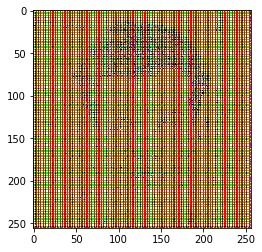

In [35]:
frnt, side = load('data/train/mugshot_comp.111.png')

gen_out = generator(frnt[tf.newaxis,...], training=False)
plt.imshow(gen_out[0,...])

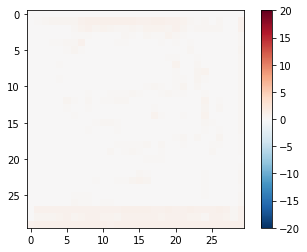

In [36]:
dis_out = discriminator([frnt[tf.newaxis,...], gen_out], training=False)
plt.imshow(dis_out[0,...,-1], vmin=-20, vmax=20, cmap='RdBu_r')
plt.colorbar()

### Loss function

In [37]:
# l1_weight and gan_weight are taken from the Image-to-Iamge paper.
# The numbers scale the two components of the loss function in the GAN.
l1_weight = 100.0
gan_weight = 1.0

# Epsilon
epsilon = 1e-12

In [38]:
def discriminator_loss(real_output, fake_output): 
    total_loss = tf.reduce_mean(-(tf.math.log(real_output + epsilon) + tf.math.log(1 - fake_output + epsilon)))
    return total_loss

In [39]:
def generator_loss(fake_output, target_images, generated_images):
    gen_loss_GAN = tf.reduce_mean(-tf.math.log(fake_output + epsilon))
    gen_loss_L1 = tf.reduce_mean(tf.math.abs(target_images - generated_images))
    total_loss = gen_loss_GAN * gan_weight + gen_loss_L1 * l1_weight
    return total_loss

In [49]:
gen_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.99, epsilon=epsilon)
dis_optimizer = tf.keras.optimizers.Adam(learning_rate=2e-4, beta_1=0.5, beta_2=0.99, epsilon=epsilon)

### Checkpoint

In [41]:
checkpoint_dir = 'data/training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                 discriminator_optimizer=discriminator_optimizer,
                                 generator=generator,
                                 discriminator=discriminator)

### Training

In [42]:
EPOCHS = 200

In [43]:
def generate_images(model, test_input, tar):
    # the training=True is intentional here since
    # we want the batch statistics while running the model
    # on the test dataset. If we use training=False, we will get
    # the accumulated statistics learned from the training dataset
    # (which we don't want)
    prediction = model(test_input, training=True)
    plt.figure(figsize=(15,15))

    display_list = [test_input[0], tar[0], prediction[0]]
    title = ['Input Image', 'Ground Truth', 'Predicted Image']

    for i in range(3):
        plt.subplot(1, 3, i+1)
        plt.title(title[i])
        # getting the pixel values between [0, 1] to plot it.
        plt.imshow(display_list[i] * 0.5 + 0.5)
        plt.axis('off')
    plt.show()

In [51]:
@tf.function
def train_step(input_image, target):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as dis_tape:
        gen_output = generator(input_image, training=True)

        dis_real_output = discriminator([input_image, target], training=True)
        dis_generated_output = discriminator([input_image, gen_output], training=True)

        gen_loss = generator_loss(dis_generated_output, gen_output, target)
        dis_loss = discriminator_loss(dis_real_output, dis_generated_output)

    gen_gradients = gen_tape.gradient(gen_loss, generator.trainable_variables)
    dis_gradients = dis_tape.gradient(dis_loss, discriminator.trainable_variables)

    gen_optimizer.apply_gradients(zip(gen_gradients, generator.trainable_variables))
    dis_optimizer.apply_gradients(zip(dis_gradients, discriminator.trainable_variables))

In [47]:
def train(dataset, epochs):
    for epoch in range(epochs):
        start = time.time()

        for input_image, target in dataset:
            train_step(input_image, target)

        clear_output(wait=True)
        for inp, tar in test_dataset.take(1):
            generate_images(generator, inp, tar)

        # saving (checkpoint) the model every 20 epochs
        if (epoch + 1) % 20 == 0:
            checkpoint.save(file_prefix = checkpoint_prefix)

        print ('Epoch {} took {} sec\n'.format(epoch + 1, time.time()-start))

In [52]:
train(trainset, EPOCHS)

NameError: name 'clear_output' is not defined

### Restore checkpoint

In [ ]:
# restoring the latest checkpoint in checkpoint_dir
checkpoint.restore(tf.train.latest_checkpoint(checkpoint_dir))

### Generate image from test dataset

In [ ]:
# Run the trained model on the entire test dataset
for inp, tar in testset.take(5):
    generate_images(generator, inp, tar)